In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jane-fastai-nn5-150-150-150/Jane_nn5_150_150_150.pth
/kaggle/input/jane-street-market-prediction/example_sample_submission.csv
/kaggle/input/jane-street-market-prediction/features.csv
/kaggle/input/jane-street-market-prediction/example_test.csv
/kaggle/input/jane-street-market-prediction/train.csv
/kaggle/input/jane-street-market-prediction/janestreet/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/jane-street-market-prediction/janestreet/__init__.py


In [2]:
HIDDEN_LAYERS = [150, 150, 150]

In [3]:
import os
import gc
import pandas as pd
import numpy as np

from   sklearn.pipeline import Pipeline
from   sklearn.impute import SimpleImputer
from   sklearn.preprocessing import StandardScaler

import torch.nn as nn

from   fastai.basics import Recorder
from   fastai.callback import *
from   fastai.callback.all import *
from   fastai.callback.training import GradientClip
from   fastai.callback.all import SaveModelCallback, EarlyStoppingCallback, ReduceLROnPlateau 
from   fastai.tabular.all import TabularPandas, RandomSplitter, CategoryBlock, MultiCategoryBlock, range_of, accuracy, tabular_learner, TabularDataLoaders
from   fastai.metrics import RocAucMulti

from   functools import partial
import warnings
warnings.filterwarnings ("ignore")

In [4]:
# Global Vars
TP   = None
DF   = None
DLs  = None
PIPE = None

In [5]:
def preprocess_data (filename='../input/jane-street-market-prediction/train.csv', df=None, isTrainData=True):
    
    global PIPE
    dtype = None
    if isTrainData:
        
        dtype = {
            'date'      : 'int64', 
            'weight'    : 'float32',
            'resp'      : 'float32',
            'ts_id'     : 'int64',  
            'feature_0' : 'float32'
        }
    else:
        
        dtype = {
            'date'      : 'int64', 
            'weight'    : 'float32',
            'feature_0' : 'float32'
        }
    for i in range (1, 130):
        k = 'feature_' + str (i)
        dtype[k] = 'float32'
    
    to   = None
    if isTrainData:
        df         = pd.read_csv (filename, dtype=dtype)
        df         = df.query ('date > 85')
        df         = df[df['weight'] != 0].reset_index (drop = True)
        
        resp_cols  = ['resp_1', 'resp_2', 'resp_3','resp_4', 'resp']    
        # df[:5000].to_csv (filename+'.dummy', index=False) 
        y          = np.stack ([(df[c] > 0).astype ('int') for c in resp_cols]).T
        df.drop (columns=['weight', 'date', 'ts_id']+resp_cols, inplace=True)
        f_columns  = [c for c in df.columns if "feature" in c]
        PIPE       = Pipeline ([
                        ("imputer", SimpleImputer (missing_values=np.nan, strategy='mean')),
                        # ("stand",   StandardScaler (with_mean=False))
        ])
        columns    = list (df.columns) + resp_cols
        X          = PIPE.fit_transform (df)
        df         = pd.DataFrame (np.hstack ((X, y)))
        df.columns = columns
        del X, y

        splits    = RandomSplitter (valid_pct=0.05) (range_of (df))
        to        = TabularPandas (df, cont_names=f_columns, cat_names=None, y_names=resp_cols, y_block=MultiCategoryBlock(encoded=True, vocab=resp_cols), splits=splits)
    else:
        
        df         = df.drop (columns=['weight', 'date']).reset_index (drop = True)
        columns    = df.columns
        X          = PIPE.transform (df)
        df         = pd.DataFrame (X)
        df.columns = columns
        # del X
    return to, df

In [6]:
TP, DF = preprocess_data ()
TP.xs.iloc[:2]

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_120,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_128,feature_129
1324191,-1.0,0.731624,0.025736,-0.179517,-0.137067,-0.381154,-0.261079,0.038627,0.013857,0.253029,...,0.367166,0.188722,-0.138776,0.772664,0.092798,2.092194,0.128738,1.519128,-0.063005,0.942904
1435630,1.0,-1.901653,-1.245931,1.170142,2.130519,0.741562,1.412086,0.126922,0.612173,-1.946766,...,-1.597749,0.326592,-1.521530,0.800413,-1.474463,-0.012462,-2.483249,0.015142,-1.823898,0.657958


In [7]:
TP.ys.iloc[:2]

,resp_1,resp_2,resp_3,resp_4,resp
1324191,0.0,0.0,1.0,1.0,1.0
1435630,0.0,0.0,1.0,1.0,1.0


In [8]:
TP.xs.shape, TP.ys.shape

((1571415, 130), (1571415, 5))

In [9]:
DLs = TP.dataloaders (bs=10000)
DLs.show_batch ()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,feature_79,feature_80,feature_81,feature_82,feature_83,feature_84,feature_85,feature_86,feature_87,feature_88,feature_89,feature_90,feature_91,feature_92,feature_93,feature_94,feature_95,feature_96,feature_97,feature_98,feature_99,feature_100,feature_101,feature_102,feature_103,feature_104,feature_105,feature_106,feature_107,feature_108,feature_109,feature_110,feature_111,feature_112,feature_113,feature_114,feature_115,feature_116,feature_117,feature_118,feature_119,feature_120,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_128,feature_129,resp_1,resp_2,resp_3,resp_4,resp
0,-1.0,0.685630,-1.061759,3.591890,1.651145,1.956211,0.814766,3.349169,1.843131,1.678790,-0.346575,1.589472,0.746679,2.979699,0.753235,1.994952,0.223535,-0.478744,-0.301536,-1.462398,-0.905539,-1.357951,-0.346518,-1.480101,-0.877771,-1.830482,-1.011808,3.774489,2.728277,2.587893,1.270614,3.788974,2.941726,4.224976,2.146409,3.783111,1.522714,-1.632880,-0.866169,3.530819,2.792718,0.245185,2.437015,4.939965,0.495094,1.189234,2.693787,2.445892,1.063177,0.051655,1.785599,0.541335,1.678412,1.700554,-0.177643,0.385433,0.296422,0.685222,0.647313,0.621681,-0.280108,-0.241733,-0.887534,-0.953315,-1.193814,-0.028631,-0.015806,0.034681,0.040525,1.063584,-1.218410,-0.628428,1.437052,0.145510,1.151809,1.784689,0.111129,-0.156807,4.403599,0.191338,3.138193,5.382243,0.140391,-0.740126,0.564638,0.331784,0.860071,2.520484,0.280008,0.360477,2.531776,1.608662,3.271437,5.837792,1.226651,2.362491,-0.570650,0.131442,-0.185792,-0.044051,0.085855,0.300483,0.761600,0.678510,0.821562,1.018720,1.355899,2.330554,0.221926,-0.817788,0.429034,0.855220,-0.571322,0.403012,1.749789,1.012129,2.685179,4.578251,1.434220,1.869550,1.508619,-0.359133,1.601929,-0.299275,1.480354,-0.281956,2.316972,-0.064304,1.960531,-0.187570,True,False,False,False,False
1,1.0,2.056480,1.775768,-1.174969,-0.943603,0.152191,0.109942,1.001140,0.985612,0.745089,0.318562,-0.696285,-1.149692,-1.506565,-1.230646,0.463700,0.308885,1.185898,1.438377,1.278959,1.340219,0.971703,0.500679,1.221140,1.279940,1.387992,1.354474,-0.550282,-0.802763,-0.837119,-0.988314,-0.657781,-1.141613,-1.190513,-1.161955,-1.249330,-0.972373,0.943065,0.875117,-1.228276,-1.813003,0.452085,-0.691936,0.703934,-2.306975,-0.431190,1.379654,1.679187,1.529421,1.285744,3.026960,2.110380,0.897768,-0.158153,0.963622,0.712870,-0.142294,-0.114362,-0.105967,0.582248,1.506469,1.338822,-0.114187,-0.128157,-0.520606,-0.688529,-0.505014,0.611785,0.605151,1.697037,3.936849,1.143288,-0.682267,-1.361692,-0.050416,0.122148,-1.308689,-1.520601,-1.715159,-2.024343,-0.102263,0.208811,-1.907219,-2.165300,0.710951,-1.238212,0.085182,0.951178,-1.641860,-0.202369,1.662355,-1.515613,0.626197,1.530325,-1.086886,0.608574,1.050085,1.770901,0.142827,0.476330,1.095548,0.092282,2.345103,2.913483,0.551640,1.209584,2.877603,0.974829,1.301099,0.496043,0.032569,0.397048,0.136091,-0.069328,1.894271,1.931812,0.775257,1.839425,1.304232,0.608629,-0.518859,0.480340,-0.308866,0.750707,-0.480558,0.376870,-0.752263,0.177049,-0.614484,0.221749,True,True,True,True,True
2,-1.0,1.759792,2.478822,-2.646600,-3.14

In [10]:
DLs.one_batch ()[2].shape

torch.Size([10000, 5])

In [11]:
x_cat, x_cont, y = DLs.train.one_batch ()
x_cat.shape, x_cont.shape, y.shape

(torch.Size([10000, 0]), torch.Size([10000, 130]), torch.Size([10000, 5]))

In [12]:
# for vanilla NN use this
# path  = "../input/jane-fastai-nn5-150-150-150/Jane_nn5_150_150_150"
learn = tabular_learner (DLs, layers=HIDDEN_LAYERS, 
                         loss_func=nn.BCEWithLogitsLoss (), metrics=RocAucMulti ()) #, model_dir='/kaggle/working/')
# learn = learn.load (path)
learn.summary ()

TabularModel (Input shape: 10000 x torch.Size([10000, 130]))
Layer (type)         Output Shape         Param #    Trainable 
                     10000 x 130         
BatchNorm1d                               260        True      
BatchNorm1d                               260        True      
____________________________________________________________________________
                     10000 x 150         
Linear                                    19500      True      
ReLU                                                           
BatchNorm1d                               300        True      
Linear                                    22500      True      
ReLU                                                           
BatchNorm1d                               300        True      
Linear                                    22500      True      
ReLU                                                           
__________________________________________________________________________

In [13]:
logits = learn.model (x_cat, x_cont)
logits

tensor([[ 0.1890, -0.0033, -0.0644, -0.1430, -0.0619],
        [ 0.1185,  0.0686, -0.0206, -0.0859, -0.0633],
        [ 0.1387,  0.0504,  0.0091, -0.1366, -0.0562],
        ...,
        [ 0.2374,  0.0115, -0.0381, -0.1559, -0.0844],
        [ 0.2122, -0.0593, -0.0716, -0.1179, -0.1354],
        [ 0.3784, -0.0700,  0.1530, -0.3574, -0.1611]],
       grad_fn=<AddmmBackward>)

In [14]:
x_cat, x_cont, y = learn.dls.one_batch ()
init_loss = learn.loss_func (learn.model (x_cat, x_cont), y)
init_loss

tensor(0.6951, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)

(0.0043651584535837175, 0.00021379621466621757)

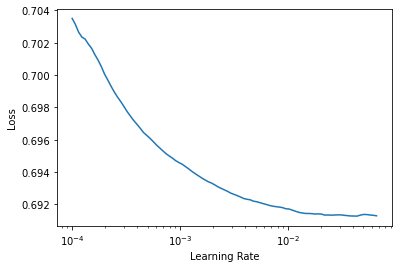

In [15]:
lr_min, lr_steep = learn.lr_find (start_lr=1e-4, end_lr=0.1, num_it=100)
lr_min, lr_steep

In [16]:
modelfile='Jane_nn5_'+str (HIDDEN_LAYERS).replace (' ', '_').replace (',', '').replace ('[', '').replace (']', '')
callbacks = [
    # by default monotor = "valid_loss" in these
    EarlyStoppingCallback (monitor='roc_auc_score', min_delta=0.00001, patience=20),
    SaveModelCallback (monitor='roc_auc_score', fname=modelfile),
    ReduceLROnPlateau (monitor='roc_auc_score', min_delta=0.0001, factor=2.0, min_lr=1e-8, patience=1),
    GradientClip (1.0)
]

epochs  = 100
lr      = lr_min
learn.fit_one_cycle (epochs, lr, wd=1e-2, cbs=callbacks)

epoch,train_loss,valid_loss,roc_auc_score,time
0,0.690172,0.689351,0.543636,00:32
1,0.688309,0.688304,0.549139,00:32
2,0.687512,0.687665,0.552596,00:31
3,0.686698,0.687081,0.555048,00:31
4,0.685943,0.686654,0.557292,00:31
5,0.685247,0.686393,0.556723,00:31
6,0.684578,0.685402,0.561941,00:30
7,0.684015,0.685237,0.562144,00:30
8,0.683378,0.684990,0.562718,00:29
9,0.682760,0.684761,0.565065,00:29


Better model found at epoch 0 with roc_auc_score value: 0.5436357784128211.
Better model found at epoch 1 with roc_auc_score value: 0.5491391427475574.
Better model found at epoch 2 with roc_auc_score value: 0.5525959246956667.
Better model found at epoch 3 with roc_auc_score value: 0.5550477348799732.
Better model found at epoch 4 with roc_auc_score value: 0.5572917552350615.
Epoch 5: reducing lr to 0.0003706413917401978
Better model found at epoch 6 with roc_auc_score value: 0.5619408930690113.
Better model found at epoch 7 with roc_auc_score value: 0.5621444583714382.
Better model found at epoch 8 with roc_auc_score value: 0.5627181168740629.
Better model found at epoch 9 with roc_auc_score value: 0.5650654201941229.
Better model found at epoch 10 with roc_auc_score value: 0.5659141421906124.
Better model found at epoch 11 with roc_auc_score value: 0.5701278112304402.
Better model found at epoch 12 with roc_auc_score value: 0.5702473791739657.
Better model found at epoch 13 with roc

In [17]:
from fastai.imports import *
from fastai.torch_core import *
from fastai.learner import *
    
@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()

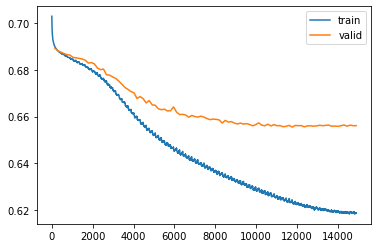

In [18]:
learn.recorder.plot_loss (skip_start=0, with_valid=True)

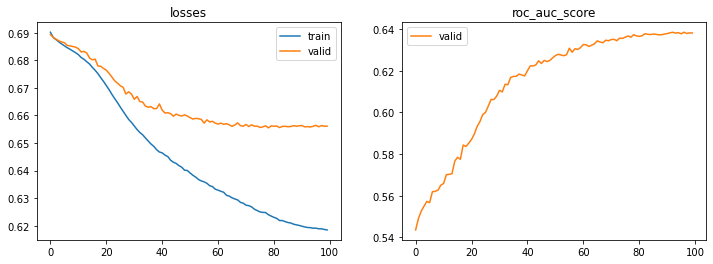

In [19]:
learn.recorder.plot_metrics ()

(7.413102430291474e-05, 0.00034673683694563806)

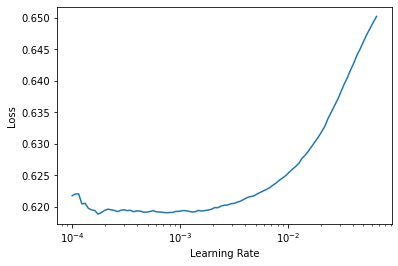

In [20]:
lr_min, lr_steep = learn.lr_find (start_lr=1e-4, end_lr=0.1, num_it=100)
lr_min, lr_steep

In [21]:
epochs  = 80
lr      = lr_min
learn.fit_one_cycle (epochs, lr, wd=1e-2, cbs=callbacks)

epoch,train_loss,valid_loss,roc_auc_score,time
0,0.618543,0.655885,0.638186,00:29
1,0.618744,0.655864,0.638248,00:29
2,0.618597,0.656137,0.637753,00:29
3,0.618699,0.655928,0.638261,00:29
4,0.618749,0.655843,0.637979,00:29
5,0.618787,0.656094,0.638290,00:29
6,0.618675,0.655887,0.638400,00:29
7,0.618939,0.655986,0.637875,00:30
8,0.618638,0.655814,0.638206,00:30
9,0.618862,0.655982,0.638078,00:29


Better model found at epoch 0 with roc_auc_score value: 0.6381860724936933.
Better model found at epoch 1 with roc_auc_score value: 0.6382483026816572.
Epoch 1: reducing lr to 2.347609206870705e-06
Epoch 2: reducing lr to 3.4132657389117916e-06
Better model found at epoch 3 with roc_auc_score value: 0.6382613692445396.
Epoch 3: reducing lr to 4.86946764547793e-06
Epoch 4: reducing lr to 6.680358535307123e-06
Better model found at epoch 5 with roc_auc_score value: 0.6382897673260277.
Better model found at epoch 6 with roc_auc_score value: 0.6383996553800302.
Epoch 7: reducing lr to 1.3758372175482742e-05
Epoch 8: reducing lr to 1.6472348061618038e-05
Epoch 9: reducing lr to 1.9255309916687654e-05
Epoch 10: reducing lr to 2.203873526181648e-05
Epoch 11: reducing lr to 2.4754085249762948e-05
Epoch 12: reducing lr to 2.7334495950287036e-05
Epoch 13: reducing lr to 2.971643519734386e-05
Epoch 14: reducing lr to 3.1841248544019576e-05
Epoch 15: reducing lr to 3.365661600897106e-05
Epoch 16: 

(1.995262282434851e-05, 0.0006456542178057134)

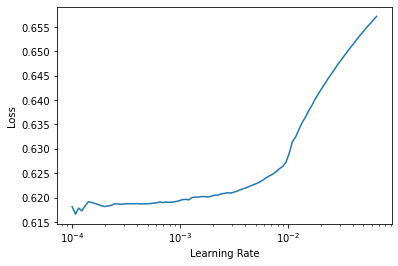

In [22]:
lr_min, lr_steep = learn.lr_find (start_lr=1e-4, end_lr=0.1, num_it=100)
lr_min, lr_steep

In [23]:
epochs  = 30
lr      = lr_min
learn.fit_one_cycle (epochs, lr, wd=1e-2, cbs=callbacks)

epoch,train_loss,valid_loss,roc_auc_score,time
0,0.618549,0.656007,0.637968,00:46
1,0.618836,0.656124,0.638031,00:41
2,0.618867,0.656095,0.637778,00:40
3,0.618609,0.656009,0.638366,00:41
4,0.618339,0.656055,0.637928,00:39
5,0.618794,0.656078,0.638400,00:37
6,0.618859,0.656126,0.638081,00:37
7,0.618556,0.655959,0.638102,00:40
8,0.618798,0.656068,0.638133,00:38
9,0.618654,0.655975,0.638409,00:36


Better model found at epoch 0 with roc_auc_score value: 0.6379680385149128.
Better model found at epoch 1 with roc_auc_score value: 0.6380308912383594.
Epoch 1: reducing lr to 1.9734716905360167e-06
Epoch 2: reducing lr to 3.6951164727291607e-06
Better model found at epoch 3 with roc_auc_score value: 0.638366068212937.
Epoch 4: reducing lr to 7.570328298787071e-06
Better model found at epoch 5 with roc_auc_score value: 0.6383996466066126.
Epoch 5: reducing lr to 9.053836620535261e-06
Epoch 6: reducing lr to 9.868850974836285e-06
Epoch 7: reducing lr to 9.964484513545817e-06
Epoch 8: reducing lr to 9.868279041766687e-06
Better model found at epoch 9 with roc_auc_score value: 0.6384085323386179.
Epoch 9: reducing lr to 9.677088500500225e-06
Epoch 10: reducing lr to 9.394634143005546e-06
Epoch 11: reducing lr to 9.026413715956197e-06
Epoch 12: reducing lr to 8.57959417043744e-06
Epoch 13: reducing lr to 8.06287252349169e-06
Epoch 14: reducing lr to 7.4863058270916895e-06
Epoch 15: reducin

In [24]:
# learn.recorder.plot_lr ()

<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

In [25]:
_, logits, _ = learn.predict (DF.iloc[0])
logits

ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

# Prediction

In [26]:
MODEL = learn.model
MODEL

TabularModel(
  (embeds): ModuleList()
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(130, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): BatchNorm1d(130, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=130, out_features=150, bias=False)
      (2): ReLU(inplace=True)
    )
    (1): LinBnDrop(
      (0): BatchNorm1d(150, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=150, out_features=150, bias=False)
      (2): ReLU(inplace=True)
    )
    (2): LinBnDrop(
      (0): BatchNorm1d(150, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=150, out_features=150, bias=False)
      (2): ReLU(inplace=True)
    )
    (3): LinBnDrop(
      (0): Linear(in_features=150, out_features=5, bias=True)
    )
  )
)

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils.rnn as rnn_utils
from   torch.autograd import Variable
from   torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler

DEVICE = torch.device ("cuda:0") if torch.cuda.is_available () else torch.device ("cpu")

# For direct submission, without using Fastai since its too slow
Use Fastai for training models only, not for prediction.

In [28]:
def predict_torch (test_df):
    
    test_df.drop (columns=['weight', 'date'], inplace=True)
    test_df.reset_index (drop=True, inplace=True)
    test_df = PIPE.transform (test_df)        
    test_df = torch.tensor (test_df).float ().view (-1, 130)
    predictions = []
    for i in range (test_df.shape[0]):
        
        pred_p = torch.sigmoid (MODEL (None, test_df)).detach ().cpu ().numpy ().reshape ((-1, 5))
        predictions.append (pred_p)

    predictions = np.vstack (predictions).reshape ((-1, 5))
    predictions = np.median (predictions, axis=1)
    return (predictions >= 0.5).astype (int)

# For prediction using Fastai
Don't use thism its too slow and times out. Use Pytorch for prediction.
Use Fastai for training the Pytorch models only.

In [29]:
import torch.nn.functional as F

def predict (df, threshold=0.50):
    
    dl     = learn.dls.test_dl (df)
    logits = learn.get_preds (dl=dl)[0]
    probs  = F.sigmoid (logits).detach ().numpy ()
    pred   = (np.median (probs, axis=1) >= threshold).astype (int)
    return pred

test_df = DF.copy()
resp_cols  = ['resp_1', 'resp_2', 'resp_3','resp_4', 'resp']
test_df.drop (columns=resp_cols, inplace=True)

test_df  = preprocess_data (df=test_df, isTrainData=False)
predict (test_df)

# Test

In [30]:
import janestreet
env      = janestreet.make_env ()  # initialize the environment
env_iter = env.iter_test ()        # an iterator which loops over the test set

In [31]:
for test_df, pred_df in env_iter:
    if test_df["weight"].item () > 0:
        
        pred_df.action = predict_torch (test_df)
    else:
        pred_df.action = 0
        
    # print (pred_df)
    # print ("--------------")
    env.predict (pred_df)

In [32]:
print ('Done !')

Done !
